# Purpose of this notebook

This notebook demonstrates how to parse molecular structures from the web using a Jupyter notebook.  In addition to standard modules such as `numpy`, this notebook uses these specialized Python modules:

* `rdkit` - the best available open python package for representing and computing on molecules in 2D and in 3D
* `pandas` - this the python package that adds support for `R`-like data frames (_annotated_ tabular data) in python.  It also includes some nice tools for scraping HTML data tables, as we shall see.

The notebook begins with `import` statements, telling the interpreter what files to load.

# Setup: importing required python modules

In [1]:
# numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

# scipy
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as hc

# seaborn -- for better looking plots
import seaborn as sns

# pandas 
import pandas as pd

# rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors

# Scraping data from the web

The demonstration data for this notebook comes from the URL **`http://sgtc-svr102.stanford.edu/hiplab/compounds/browse/2/`** .  This page lists SMILES structures for compounds from the TimTec natural products library of ~800 compounds.  More information on the TimTec library is available from the vendor at **`http://www.timtec.net/natural-compound-library.html`** .  To access the stanford URL, VPN access to Stanford's network is likely required.

The table is parsed into python's `pandas` package using the convenient `pandas` function `read_html()`.  This function returns a _list_ of all the tables found on the given page.  Our page of interest contains only one table, so this list is only one element long.  Each element of the list is a `pandas` DataFrame.

In [2]:
url = 'http://sgtc-svr102.stanford.edu/hiplab/compounds/browse/2/'

list_of_tables = pd.read_html(url)

# the _only_ table on the page is the first table in the list
table = list_of_tables[0]

# Turning strings into rdkit molecules

The **SMILES** column contains molecule structural information in the [simplified molecular input line entry system](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) nomenclature.  Click the link for more info.

Now that the table is structured into a data table, the strings that represent each structure can be parsed into molecules that the `rdkit` package understands.  Only the **SMILES** column of the DataFrame needs to be parsed.  For each SMILES structure (i.e. each row of the DataFrame), we both instantiate a `rdkit` molecule object for the structure as well as compute a fingerprint for that structure.  A molecular `fingerpint` is a bit vector that is computed from the molecular structure.  Since it is just a numerical vector, it allows rapid comparison of two molecules.  You can read some more about how fingerprints are computed in `rdkit`'s documentation [here](http://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity).  There is also useful information in a 2012 [slide deck](http://rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf) (pdf) by the principal author of `rdkit`, Greg Landrum.  
* There is a large library in `rdkit` called `Fingerprints.FingerprintMols`, which [seems]( http://www.rdkit.org/Python_Docs/rdkit.Chem.Fingerprints.FingerprintMols-module.html) like it would have the requisite functionality for fingerprinting, but according to [this 2014 archived email correspondence from Greg Landrum](https://sourceforge.net/p/rdkit/mailman/rdkit-discuss/thread/CAOSYiOLVNk3eUzEm-oWmWN81qY8WBFzvmjeg_1j1od_QJcgF7w@mail.gmail.com/), this entire module should be deprecated.  The `rdmolops.RDKFingerprint()` function is the one to use.

If `rdkit` cannot parse a SMILES string for whatever reason, it will return `None`.  If you try to do **`FingerprintMols.FingerprintMol(None)`**, it will generate an error.  Thus an rdkit failure to parse must specifically be checked and handled separately.  This is what the `if`...`else`...`continue`... loop does below.


In [8]:
smiles_list = table['SMILES']

mols = []
fingerprints = []

for idx, smiles in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols.append(mol)
    else:
        print 'Unable to parse item %s, SMILES string %s and so this molecule will be skipped.' % (idx, smiles)
        print 'Please check validity of this string or manually remove it from smiles_list.'
        continue
    
fingerprint_mat = np.vstack(np.asarray(rdmolops.RDKFingerprint(mol, fpSize = 2048), dtype = 'bool') for mol in mols)

Unable to parse item 215, SMILES string Cl.CN1=Cc2cc3OCOc3cc2CC1 and so this molecule will be skipped.
Please check validity of this string or manually remove it from smiles_list.


In [9]:
smiles_list.pop(215)

u'Cl.CN1=Cc2cc3OCOc3cc2CC1'

Now that all fingerprints have been computed, we can find the distances between all the fingerprints.  The "fingerprint" is a bit vector, i.e. a boolean vector.  Distance metrics for comparing them should be appropriate for boolean data.  The most popular option is probably the "Tanimoto" similarity.  But as the Wikipedia page describes, "Tanimoto" distance metrics, despite being the most popular term in the chemoinformatics literature, are not true distance metrics and are very closely related to "Jaccard" similarity / distance metrics.

In [11]:
dist_mat = pdist(fingerprint_mat, 'jaccard')

dist_df = pd.DataFrame(squareform(dist_mat), index = smiles_list, columns= smiles_list)

# set a mask
mask = np.zeros_like(dist_df, dtype = 'bool')
mask[np.triu_indices_from(mask, k = 1)] = True

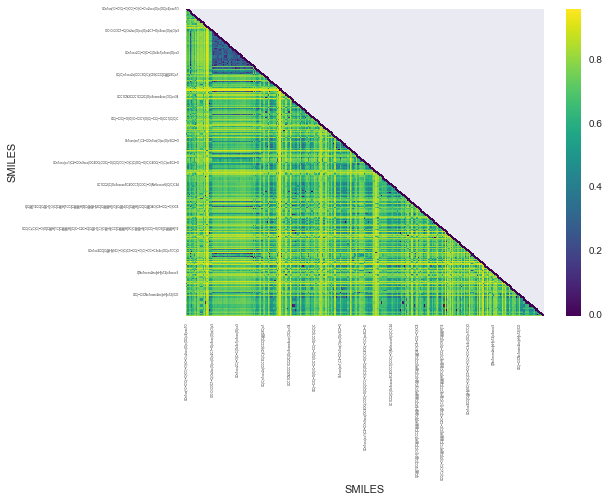

In [38]:
# plot
ax = sns.heatmap(dist_df, mask=mask, cmap = cm.viridis, xticklabels=20, yticklabels=20, )
ax.tick_params(axis='both', which='major', labelsize=3)

With a distance matrix, we can perform hierarchical clustering.  This also requires choosing a linkage method.  Here I simply use the `scipy.cluster.hierarchy.linkage()` default method, which is single linkage.  

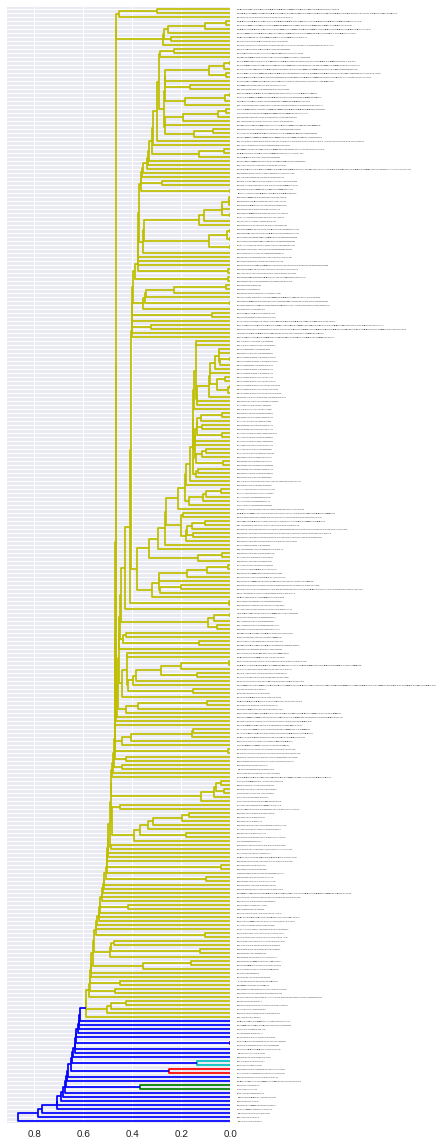

In [39]:
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
z = hc.linkage(dist_mat, metric='jaccard')
plt.figure(figsize=[4, 20])
dendrogram = hc.dendrogram(z, 
                           orientation = 'left',

                           labels = dist_df.columns,
                           show_leaf_counts = True,
                           show_contracted = True,
                           leaf_font_size = 2
                          )

plt.show()


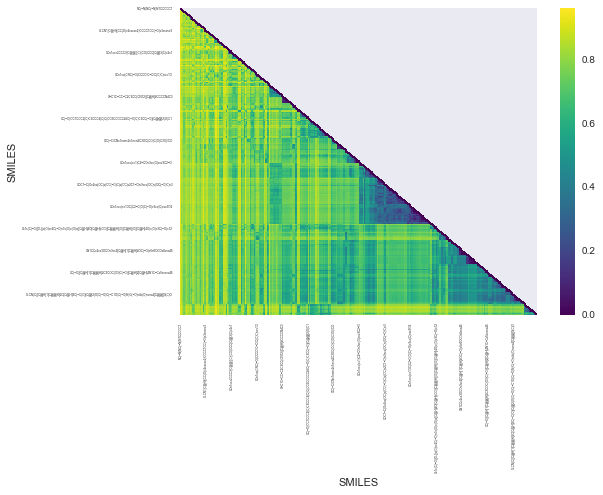

In [40]:
# reorder dist_df according to clustering results
new_order = dendrogram['ivl']

# reorder both rows and columns
reordered_dist_df = dist_df[new_order].reindex(new_order)

# plot again
ax = sns.heatmap(reordered_dist_df, mask=mask, cmap = cm.viridis, xticklabels=20, yticklabels=20)
ax.tick_params(axis='both', which='major', labelsize=3)

The distance matrix plot is now much more interpretable.  The order of molecules along the rows (and columns) is now shifted so that the similar molecules are near each other.  Off-diagonal elements of the distance matrix with very low values are as close to the diagonal as possible.  Thus, highly "blue" regions indicate groups of related molecules.  We can extract and plot a few of those.   

As a way to limit the number of structure-pairs plotted, here are choose a very stringent similarity cutoff, 0.02.  

In [108]:
low_distance = np.where(np.logical_and(dist_df <= 0.02,
                                       dist_df > 0)
                        )

similar_smiles_pairs = [indices for indices in zip(low_distance[0], low_distance[1]) 
                                          if indices[0] < indices[1]]

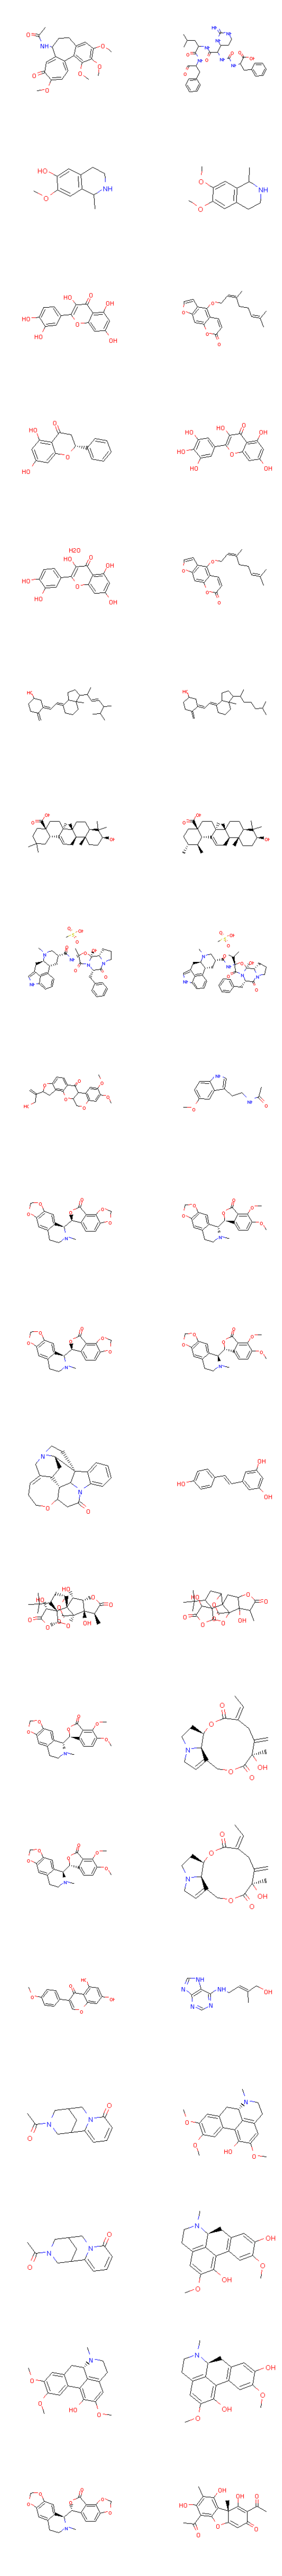

In [115]:
f, ax = plt.subplots(len(similar_smiles_pairs), 2, figsize = (10, 90))

for idx, pair in enumerate(similar_smiles_pairs):
    mol1 = Chem.MolFromSmiles(smiles_list[pair[0]])
    mol2 = Chem.MolFromSmiles(smiles_list[pair[1]])
    ax[idx, 0].imshow(Draw.MolToImage(mol1, size=(200, 200), fitImage=True))
    ax[idx, 1].imshow(Draw.MolToImage(mol2, size=(200, 200), fitImage=True))
    ax[idx, 0].grid(False)
    ax[idx, 1].grid(False)
    ax[idx, 0].axis('off')
    ax[idx, 1].axis('off')